In [37]:
import configparser
import time
import math
import pandas as pd
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [38]:
HIDDEN_SIZE = 512  # 词向量的维度和GRU输入、输出的维度
BATCH_SIZE = 128  # 一个Batch的大小
N_EPOCHS = 30  # 训练迭代次数
N_LABELS = 7   # 类别个数
N_WORDS = -1  # 词库中词的个数，计算在下面下面，这个是为了构造嵌入层
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("选择设备:", device)

选择设备: cuda:0


# **定义数据集**

In [39]:
# 定义数据集
class MessageDataset(Dataset):
    def __init__(self, is_train_set):
        super().__init__()
        # 加载配置
        conf = configparser.ConfigParser()
        conf.read('./fileConfig', encoding='utf8')
        # 加载数据文件
        processed_date = conf.get("orgFile", "processed_date")  # 处理后的数据路径
        df = pd.read_excel(processed_date)  # 读取数据
        # self.data = df[["textData", "labels"]]  # 取数据和标签
        self.data = df[["textData", "labels"]]  # 取数据和标签
        self.messages = self.data["textData"]  # 留言中文文本内容
        # self.labels = self.data["labels"]  # 留言标签
        self.labels = list(self.data["labels"])  # 留言标签
        # self.labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # 留言标签
        self.word2idx, self.idx2word, self.wordNum = self.Word_Proccess(self.messages)  # word2idx, idx2word, 数据中词的个数
        self.vecData = self.wordVectorize(self.messages)  # 每个句子的中文文本内容特征化
        if is_train_set:
            self.x_inputs, _, self.y_inputs, _ = train_test_split(self.vecData, self.labels, train_size=0.7, random_state=1)  # 按照7:3的比例划分训练集和测试集
        else:
            _, self.x_inputs, _, self.y_inputs = train_test_split(self.vecData, self.labels, train_size=0.7, random_state=1)  # 按照7:3的比例划分训练集和测试集
        self.len = len(self.x_inputs)  # 数据总个数

    def __getitem__(self, index):
        return self.x_inputs[index], self.y_inputs[index]

    def __len__(self):
        return self.len

    def Word_Proccess(self, sentences):
        word2idx = {}
        idx2word = {}
        i = 1
        for sentence in sentences:
            s = sentence.split(" ")
            for word in s:
                if word2idx.get(word) == None:
                    word2idx[word] = i
                    idx2word[i] = word
                    i += 1
        return word2idx, idx2word, i-1

    def wordVectorize(self, sentences):
        vecs = []
        for sentence in sentences:
            s = sentence.split(" ")
            vec = [self.word2idx.get(word) for word in s]
            vecs.append(vec)
        return vecs

# **划分训练集和测试集**

In [40]:
# 划分训练集和测试集
train_set = MessageDataset(True)
N_WORDS = train_set.wordNum + 1
test_set = MessageDataset(False)

In [41]:
def makeTensor(batch):
    labels = [label for _, label in batch]
    sequences_and_lengths = [(seq, len(seq)) for seq, _ in batch]

    text_sequences = [s1[0] for s1 in sequences_and_lengths]
    seq_lengths = torch.LongTensor([s1[1] for s1 in sequences_and_lengths])
    labels = torch.Tensor(labels).long()

    # make tensor of name, BatchSize * seqLen
    # 他这里补零的方式先将所有的0 Tensor给初始化出来，然后在每行前面填充每个名字
    seq_tensor = torch.zeros(len(text_sequences), seq_lengths.max()).long()
    # print("seq_lengths.max:", seq_lengths.max())
    for idx, (seq, seq_len) in enumerate(zip(text_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # sort by length to use pack_padded_sequence
    # 将名字长度降序排列，并且返回降序之后的长度在原tensor中的小标perm_idx
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    # 这个Tensor中的类似于列表中切片的方法神奇啊，直接返回下标对应的元素，相等于排序了
    seq_tensor = seq_tensor[perm_idx]
    labels = labels[perm_idx]
    # 返回排序之后名字Tensor，排序之后的名字长度Tensor，排序之后的国家名字Tensor
    return seq_tensor, seq_lengths, labels

# **创建dataloader**

In [42]:
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=makeTensor)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=makeTensor)

## **定义模型**

In [43]:
class GRUClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # 嵌入层(seqLen, batch_size) --> (seqLen, batch_size, hidden_size)
        self.embedding = torch.nn.Embedding(input_size, hidden_size, padding_idx=0)
        # GRU循环神经网络
        self.gru = torch.nn.GRU(hidden_size, hidden_size)
        # 全连接层
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, seq_lengths):
        # input shape : B x S -> S x B
        inputs = inputs.t()
        embedding = self.embedding(inputs)
        gru_input = pack_padded_sequence(embedding, seq_lengths.cpu())
        _, hidden = self.gru(gru_input)
        hidden_cat = hidden[-1]
        output = self.fc(hidden_cat)
        return output

In [51]:
classifier = GRUClassifier(N_WORDS, HIDDEN_SIZE, N_LABELS)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
classifier.to(device)  # 模型送到device
criterion.to(device)  # 损失函数送到device

CrossEntropyLoss()

# **模型训练**

In [45]:
# 训练模型
def train_model():
    def time_since(since):
        s = time.time() - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    total_loss = 0
    for i, (seq_tensor, seq_lengths, labels) in enumerate(train_dataloader, 1):
        # 数据集送到device
        seq_tensor = seq_tensor.to(device)
        seq_lengths = seq_lengths.to(device)
        labels = labels.to(device)

        output = classifier(seq_tensor, seq_lengths)
        output = output.to(device)
        
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 9 == 0:
            print(f'[{time_since(start)}] Epoch {epoch} ', end='')
            print(f'[{i * len(seq_tensor)}/{len(train_set)}] ', end='')
            print(f'loss={total_loss / (i * len(seq_tensor))}')
    return total_loss

# **模型测试**

In [46]:
# 测试模型
def model_Test():
    y_pred = []
    y_test = []
    correct = 0
    total = len(test_set)
    print("evaluating trained model ... ")
    with torch.no_grad():
        for i, (seq_tensor, seq_lengths, labels) in enumerate(test_dataloader, 1):
            # 数据集送到device
            seq_tensor = seq_tensor.to(device)
            seq_lengths = seq_lengths.to(device)
            labels = labels.to(device)

            output = classifier(seq_tensor, seq_lengths)
            output = output.to(device)
            
            # 注意这个keepdim的使用，为了直接和target计算loss
            pred = output.max(dim=1, keepdim=True)[1]
            for i in pred.view(pred.size()[0]).tolist():
                y_pred.append(i)
            for i in labels.view(labels.size()[0]).tolist():
                y_test.append(i)
            # 注意这个view_as 和 eq
            correct += pred.eq(labels.view_as(pred)).sum().item()

        percent = '%.2f' % (100 * correct / total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')
    return correct / total, y_pred, y_test

# **开始训练模型**

In [52]:
start = time.time()
print("Training for %d epochs..." % N_EPOCHS)
acc_list = []
y_pred = []  # 保存测试集标签
y_test = []  # 保留准确率最大的一次测试集预测标签
for epoch in range(1, N_EPOCHS + 1):
    # Train cycle
    train_model()
    acc, y_pred_epoch, y_test_epoch = model_Test()
    acc_list.append(acc)
    if acc >= max(acc_list):
      y_pred = y_pred_epoch
      y_test = y_test_epoch
      torch.save(classifier, "./model/GRU.pth")
print("The Best acc is:", max(acc_list))

Training for 30 epochs...
 0s] Epoch 1 [1152/6336] loss=0.014104744419455528
 1s] Epoch 1 [2304/6336] loss=0.013216605203019248
 1s] Epoch 1 [3456/6336] loss=0.012305347835300144
 2s] Epoch 1 [4608/6336] loss=0.011569903581403196
 2s] Epoch 1 [5760/6336] loss=0.011001162851850191
evaluating trained model ... 
Test set: Accuracy 1731/2716 63.73%
 4s] Epoch 2 [1152/6336] loss=0.006044626132481628
 5s] Epoch 2 [2304/6336] loss=0.005876183432216446
 6s] Epoch 2 [3456/6336] loss=0.00535105609472979
 6s] Epoch 2 [4608/6336] loss=0.005032785004004836
 7s] Epoch 2 [5760/6336] loss=0.004830098431557417
evaluating trained model ... 
Test set: Accuracy 1876/2716 69.07%
 9s] Epoch 3 [1152/6336] loss=0.002551797454038428
 9s] Epoch 3 [2304/6336] loss=0.0023901811542196404
 10s] Epoch 3 [3456/6336] loss=0.0021116421256145395
 10s] Epoch 3 [4608/6336] loss=0.002057703367124001
 11s] Epoch 3 [5760/6336] loss=0.0020706232947607837
evaluating trained model ... 
Test set: Accuracy 2021/2716 74.41%
 13s] 

# **画图、混淆矩阵**

<Figure size 432x288 with 0 Axes>

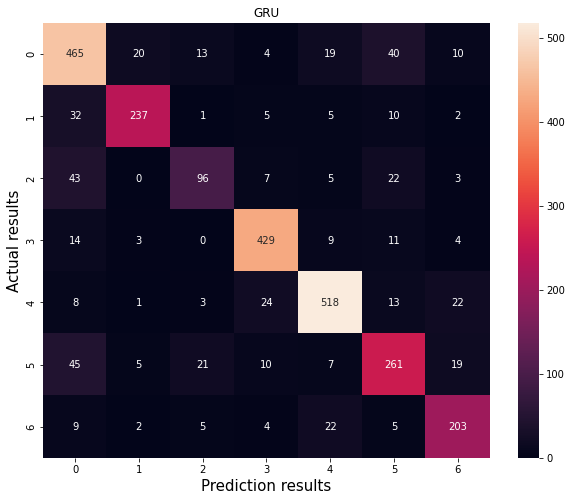

              precision    recall  f1-score   support

        城乡建设       0.75      0.81      0.78       571
        环境保护       0.88      0.81      0.85       292
        交通运输       0.69      0.55      0.61       176
        教育文体       0.89      0.91      0.90       470
     劳动和社会保障       0.89      0.88      0.88       589
        商贸旅游       0.72      0.71      0.72       368
        卫生计生       0.77      0.81      0.79       250

    accuracy                           0.81      2716
   macro avg       0.80      0.78      0.79      2716
weighted avg       0.81      0.81      0.81      2716



In [53]:
plt.figure()
conf_mat = confusion_matrix(y_test, y_pred)  # 混淆矩阵
ticklabels = ["0", "1", "2", "3", "4", "5", "6"]
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=ticklabels, yticklabels=ticklabels)
plt.ylabel('Actual results', fontsize=15)  # 设置X轴名称
plt.xlabel('Prediction results', fontsize=15)  # 设置Y轴名称
plt.title("GRU")  # 设置标题名称为模型名称
plt.savefig("./results/" + "GRU" + '_confusion_matrix.png')  # 保存混淆矩阵图片
plt.show()
# 模型评估报告，包含了Precision，Recall和F1-Score
report = classification_report(y_test, y_pred, target_names=["城乡建设", "环境保护", "交通运输", "教育文体", "劳动和社会保障", "商贸旅游", "卫生计生"])
print(report)

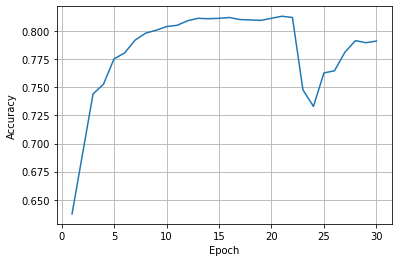

In [54]:
epoch = np.arange(1, len(acc_list) + 1)
acc_list = np.array(acc_list)
plt.plot(epoch, acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()